<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/mlp_image_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP Image Representation
#### Qian
#### April 8

Reimplement [Fourier Features Let Networks](https://bmild.github.io/fourfeat/index.html) and made a demo on one synthetic image.

Learn mapping $\Phi: \mathbf{x} \rightarrow \mathbf{v}$ with Gaussian Fourier feature mapping of input $\mathbf{x} = [x, y]$: $\gamma(\mathbf{x})= \left[ \cos(2 \pi \mathbf B \mathbf{x}), \sin(2 \pi \mathbf B \mathbf{x}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$

load image from google drive

In [20]:
# ! unzip -q drive/MyDrive/blender_512_cont.zip 

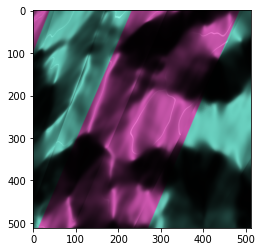

Array shape:  (512, 512, 3) dtype: float32
Array stat: max: 4.6875, min: 0.0150604248046875, mean: 1.1978672742843628, std: 1.1043531894683838


In [2]:
## load image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def load_exr(path):
    img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

img = load_exr("scene{:04d}/Image/Image0001.exr".format(0))
plt.imshow(img/img.max())
plt.show()
print_stat(img)

prepare data & dataloader

In [3]:
## construct train/test set
# Create input pixel coordinates in the unit square
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2,::2], img[::2,::2]]  ## train on 1/4 pixels

mapping_size = 256
B_gauss = np.random.normal(size=(mapping_size, 2)) * 10.

# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

class pointDataset(torch.utils.data.Dataset):
    def __init__(self, data, B, transform = None):
        self.inputs = data[0]
        self.targets = data[1]
        h, w, c = self.inputs.shape
        self.inputs = self.inputs.reshape((h * w, -1))
        self.targets = self.targets.reshape((h * w, -1))
        self.B = B
        self.transform = transform

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        X = self.inputs[index]
        Y = self.targets[index]
        X = input_mapping(X, self.B)
        if self.transform is not None:
            X = self.transform(X)
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()
        return X, Y

trainset = pointDataset(train_data, B_gauss, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testset = pointDataset(test_data, B_gauss, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [4]:
dataiter = iter(trainloader)
x, y = dataiter.next()
print(x.shape)
print(y.shape)

torch.Size([64, 512])
torch.Size([64, 3])


network

In [5]:
## build network
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class mlpImage(nn.Module):
    def __init__(self, num_layers, num_channels):
        super(mlpImage, self).__init__()
        layers = OrderedDict(
            [("linear1", nn.Linear(512, num_channels)),
             ("relu1", nn.ReLU(inplace=True)),]
        )
        for i in range(1, num_layers-1):
            layers["linear{}".format(i+1)] = nn.Linear(num_channels, num_channels)
            layers["relu{}".format(i+1)] = nn.ReLU(inplace = True)
        layers["linear{}".format(num_layers)] = nn.Linear(num_channels, 3)
        self.mlp = nn.Sequential(layers)

    def forward(self, x):
        return self.mlp(x)
device = "cuda"
model = mlpImage(4, 256).to(device)
print(model)
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

mlpImage(
  (mlp): Sequential(
    (linear1): Linear(in_features=512, out_features=256, bias=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (relu2): ReLU(inplace=True)
    (linear3): Linear(in_features=256, out_features=256, bias=True)
    (relu3): ReLU(inplace=True)
    (linear4): Linear(in_features=256, out_features=3, bias=True)
  )
)
#total params: 263683 | #trainable params: 263683


In [6]:
256 * 256 * 3

196608

In [7]:
## train network
import torch.optim as optim
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, optimizer, n_epoch, trainloader, loss_fn):
    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('epoch %d -- loss: %.3f' %
                    (epoch+1, running_loss/(i+1)))
        running_loss = 0.0

    print('Finished Training')

train(model, optimizer, 20, trainloader, loss_fn)

## validate

epoch 1 -- loss: 0.381
epoch 2 -- loss: 0.014
epoch 3 -- loss: 0.009
epoch 4 -- loss: 0.007
epoch 5 -- loss: 0.006
epoch 6 -- loss: 0.005
epoch 7 -- loss: 0.005
epoch 8 -- loss: 0.004
epoch 9 -- loss: 0.004
epoch 10 -- loss: 0.004
epoch 11 -- loss: 0.004
epoch 12 -- loss: 0.004
epoch 13 -- loss: 0.003
epoch 14 -- loss: 0.003
epoch 15 -- loss: 0.003
epoch 16 -- loss: 0.003
epoch 17 -- loss: 0.003
epoch 18 -- loss: 0.003
epoch 19 -- loss: 0.003
epoch 20 -- loss: 0.003
Finished Training


In [8]:
model.eval()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=2)
with torch.no_grad():
    img_list = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs).detach()
        img_list.append(outputs)
        loss = loss_fn(outputs, targets)
        # print statistics
        running_loss += loss.item()
    print('train loss: %.3f' %
                (running_loss/(i+1)))

train loss: 0.002


In [9]:
mlp_img = torch.cat(img_list).cpu().numpy()
mlp_img.shape

(65536, 3)

In [10]:
mlp_img = mlp_img.reshape((256, 256, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


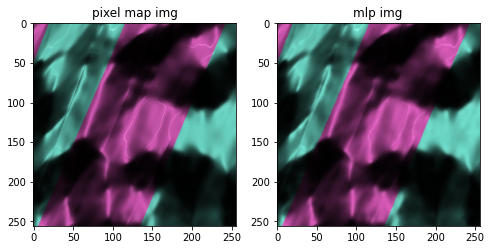

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(img[::2, ::2]/img[::2, ::2].max())
ax[0].set_title("pixel map img")
ax[1].imshow(mlp_img/mlp_img.max())
ax[1].set_title("mlp img")
plt.show()

In [12]:
mse = ((mlp_img - img[::2, ::2])**2).mean()
psnr = 10 * np.log10(img[::2, ::2].max()/mse)

print("psnr:", psnr, "mse:", mse)

psnr: 33.002281188964844 mse: 0.0023304715


network learns well w.r.t psnr. Next test rescaling capability of the pixel map and mlp representation

## test naive upsamping

cubic upscale pixel map

time: 0.007511138916015625


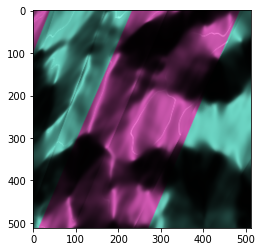

psnr: 30.708861351013184 mse: 0.003981578


In [13]:
import time
start_time = time.time()
img_resize = cv2.resize(img[::2, ::2], (0,0), fx=2, fy=2, interpolation = cv2.INTER_CUBIC) 
print("time:", time.time() - start_time)
plt.imshow(img_resize/img_resize.max())
plt.show()
mse = ((img_resize - img)**2).mean()
psnr = 10 * np.log10(img.max()/mse)

print("psnr:", psnr, "mse:", mse)

rescale mlp representation by inputting denser coodinator meshgrid

In [14]:
model.eval()
start_time = time.time()
with torch.no_grad():
    img_list = []
    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs).detach()
        img_list.append(outputs)
        loss = loss_fn(outputs, targets)
        # print statistics
        running_loss += loss.item()
    print('test loss: %.3f' %
                (running_loss/(i+1)))
mlp_img = torch.cat(img_list).cpu().numpy()
mlp_img = mlp_img.reshape((512, 512, 3))
print("time:", (time.time() - start_time))

test loss: 0.002
time: 21.193864107131958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


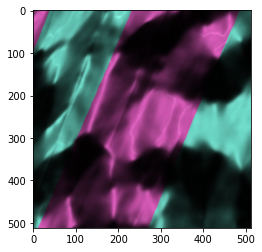

psnr: 32.75206804275513 mse: 0.0024873358


In [15]:
plt.imshow(mlp_img/mlp_img.max())
plt.show()
mse = ((mlp_img - img)**2).mean()
psnr = 10 * np.log10(img.max()/mse)

print("psnr:", psnr, "mse:", mse)

mlp representation psnr performance is better than cubic-interpolated pixel map

## ~~higher resolution:~~

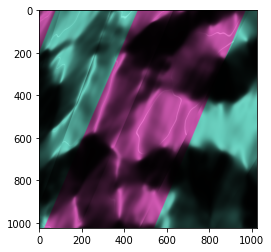

Array shape:  (1024, 1024, 3) dtype: float32
Array stat: max: 4.67578125, min: 0.0150299072265625, mean: 1.1979421377182007, std: 1.105319619178772


In [16]:
img_hr = load_exr("Image0001.exr")
plt.imshow(img_hr/img_hr.max())
plt.show()
print_stat(img_hr)

In [17]:
model.eval()
coords = np.linspace(0, 1, img_hr.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img_hr]
testset = pointDataset(test_data, B_gauss, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

start_time = time.time()
with torch.no_grad():
    img_list = []
    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs).detach()
        img_list.append(outputs)
        loss = loss_fn(outputs, targets)
        # print statistics
        running_loss += loss.item()
    print('test loss: %.3f' %
                (running_loss/(i+1)))
mlp_img = torch.cat(img_list).cpu().numpy()
mlp_img = mlp_img.reshape(img_hr.shape)
print("time:", (time.time() - start_time))

test loss: 0.004
time: 84.31788802146912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


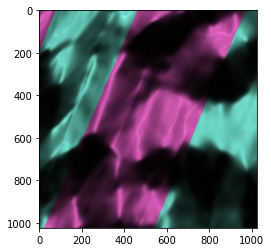

psnr: 30.513997077941895 mse: 0.0041538854


In [18]:
plt.imshow(mlp_img/mlp_img.max())
plt.show()
mse = ((mlp_img - img_hr)**2).mean()
psnr = 10 * np.log10(img_hr.max()/mse)

print("psnr:", psnr, "mse:", mse)

time: 0.007725238800048828


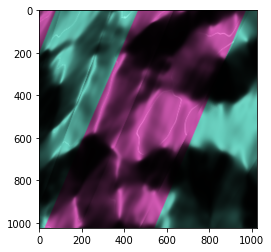

psnr: 29.45256233215332 mse: 0.005303932


In [19]:
start_time = time.time()
img_resize = cv2.resize(img[::2, ::2], (0,0), fx=4, fy=4, interpolation = cv2.INTER_CUBIC) 
print("time:", time.time() - start_time)
plt.imshow(img_resize/img_resize.max())
plt.show()
mse = ((img_resize - img_hr)**2).mean()
psnr = 10 * np.log10(img_hr.max()/mse)

print("psnr:", psnr, "mse:", mse)